<a href="https://colab.research.google.com/github/allefbcc/cienciaDeDados/blob/main/%5BPET%5D%202%C2%B0%20Fase/%5BPET%5D_%C3%81llef_Robson_Atividade_02_2%C2%B0_Fase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error as MAPE
import itertools

In [ ]:
path = 'https://raw.githubusercontent.com/allefbcc/cienciaDeDados/main/Gold%20Price.csv'
dados = pd.read_csv(path)

In [ ]:
dados

In [ ]:
dados.info()

In [ ]:
dados['Date'] = pd.to_datetime(dados['Date'])

In [ ]:
dados.info()

In [ ]:
dados = dados.set_index('Date')

In [ ]:
dados

###Criando Modelo para previsões

<Axes: xlabel='Date'>

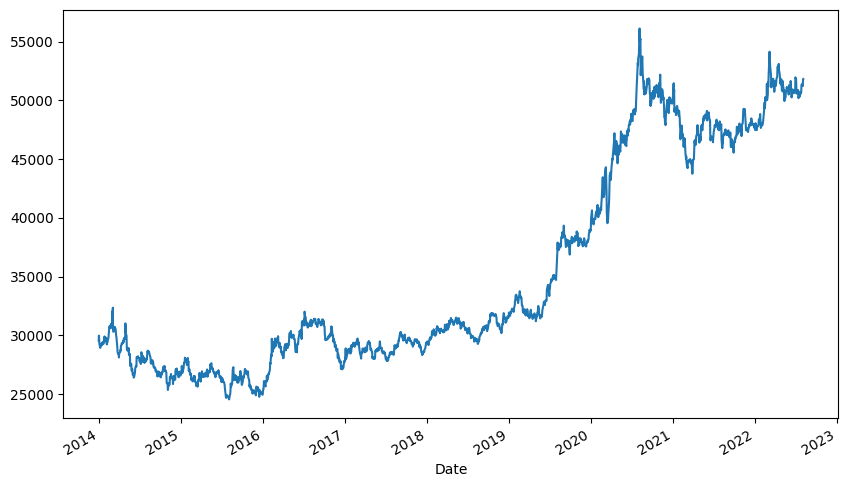

In [ ]:
plt.figure(figsize=(10, 6))
dados['Price'].plot()

<Axes: xlabel='Date'>

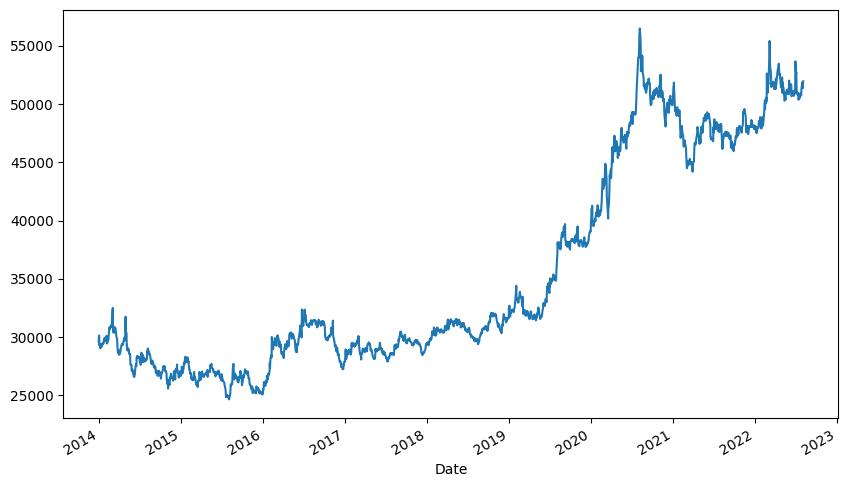

In [ ]:
plt.figure(figsize=(10, 6))
dados['High'].plot()

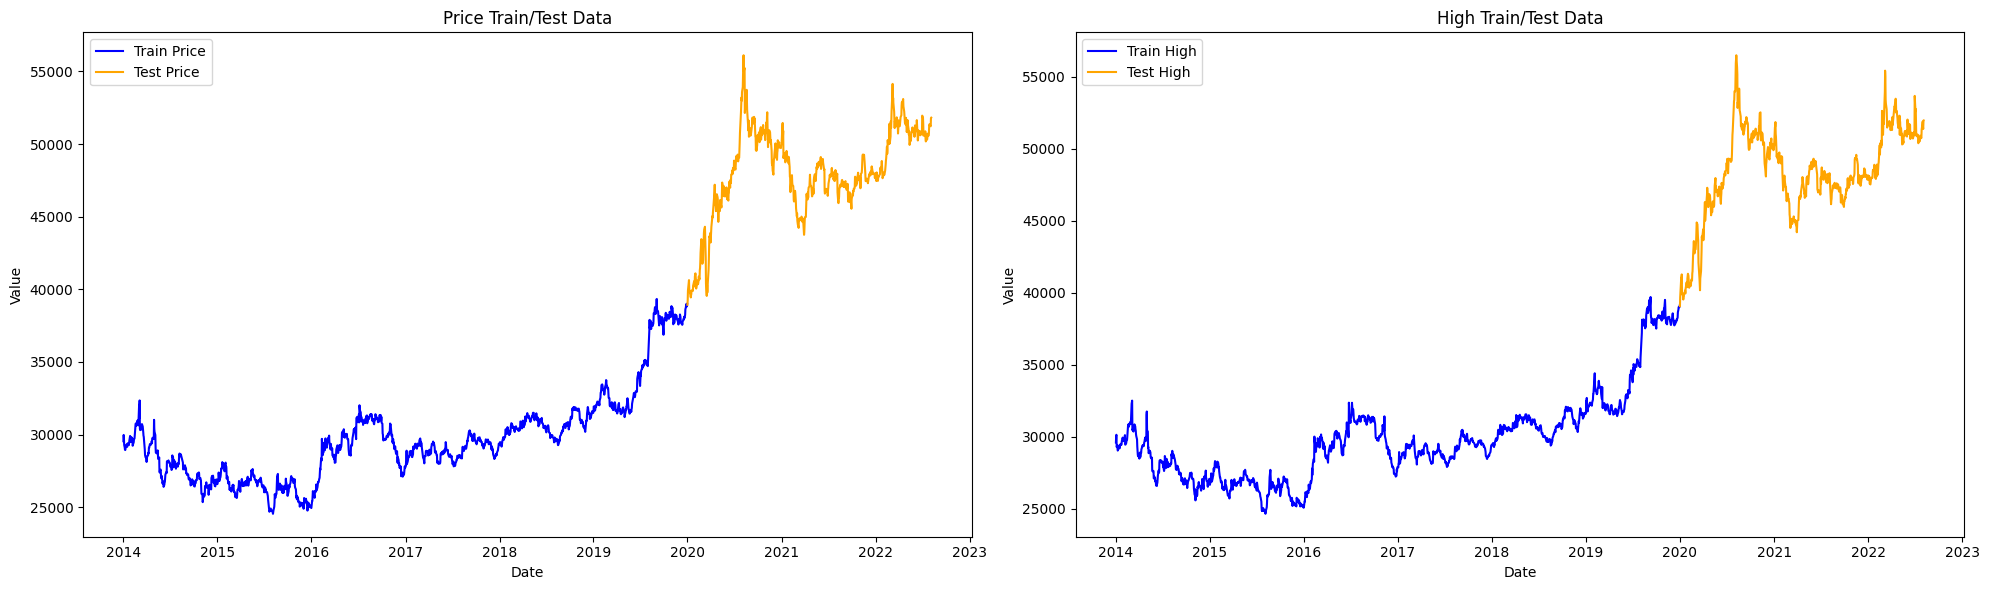

In [ ]:
train_price = dados['Price'].loc[:'2019']
test_price = dados['Price'].loc['2020':]

train_high = dados['High'].loc[:'2019']
test_high = dados['High'].loc['2020':]


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))


axes[0].plot(train_price, label='Train Price', color='blue')
axes[0].plot(test_price, label='Test Price', color='orange')
axes[0].set_title('Price Train/Test Data')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].legend(loc='best')


axes[1].plot(train_high, label='Train High', color='blue')
axes[1].plot(test_high, label='Test High', color='orange')
axes[1].set_title('High Train/Test Data')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].legend(loc='best')

plt.tight_layout()


plt.show()


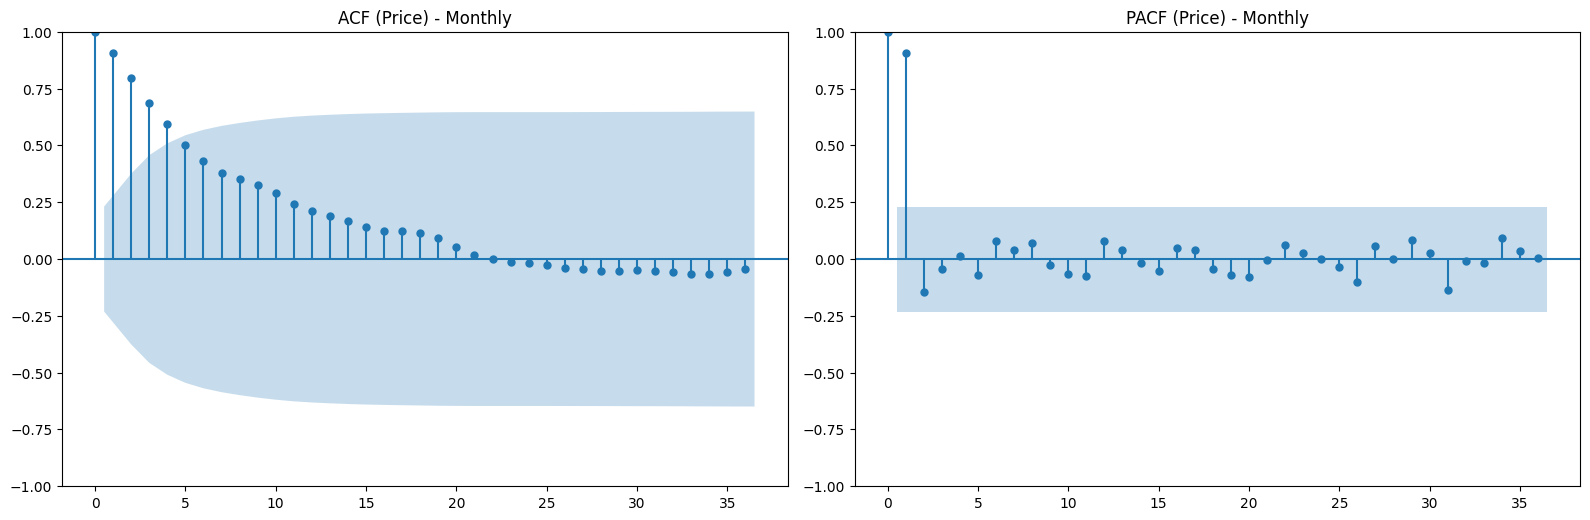

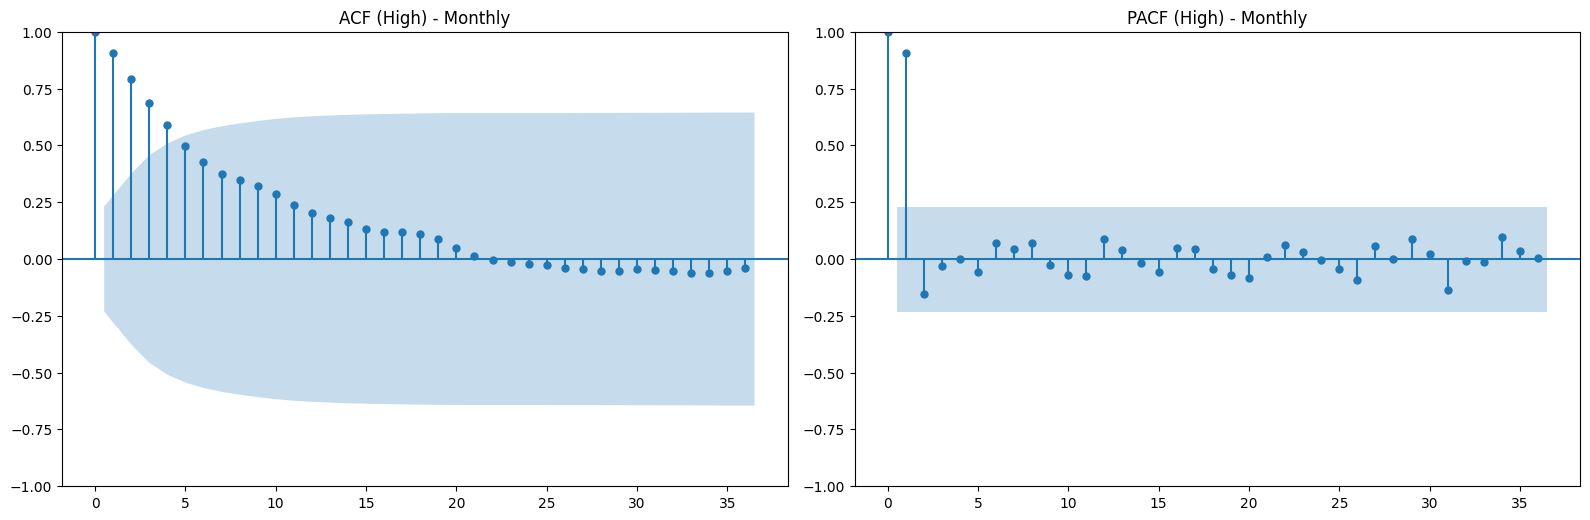

In [ ]:
def acf_pacf_monthly(data, qtd_lag, title):

    data = data.resample('M').mean()

    fig = plt.figure(figsize=(16, 10))


    ax1 = fig.add_subplot(221)
    sm.graphics.tsa.plot_acf(data, lags=qtd_lag, ax=ax1)
    ax1.set_title(f'ACF ({title}) - Monthly')


    ax2 = fig.add_subplot(222)
    sm.graphics.tsa.plot_pacf(data, lags=qtd_lag, ax=ax2)
    ax2.set_title(f'PACF ({title}) - Monthly')

    plt.tight_layout()
    plt.show()


acf_pacf_monthly(train_price, 36, 'Price')
acf_pacf_monthly(train_high, 36, 'High')


### Avaliando a estacionariedade


In [ ]:
def teste_estacionaria(serie):
  p_value = adfuller(serie)[1]
  print(p_value)
  if p_value < 0.05:
    print("Série estacionaria")
  else:
    print("Série não estacionaria")



In [ ]:
teste_estacionaria(train_price)

0.9634409380267386
Série não estacionaria


In [ ]:
teste_estacionaria(train_high)

0.9519092880840618
Série não estacionaria


### Transformando a série em estacionária

In [ ]:
teste_estacionaria(train_price.diff(1).dropna())

0.0
Série estacionaria


<Axes: xlabel='Date'>

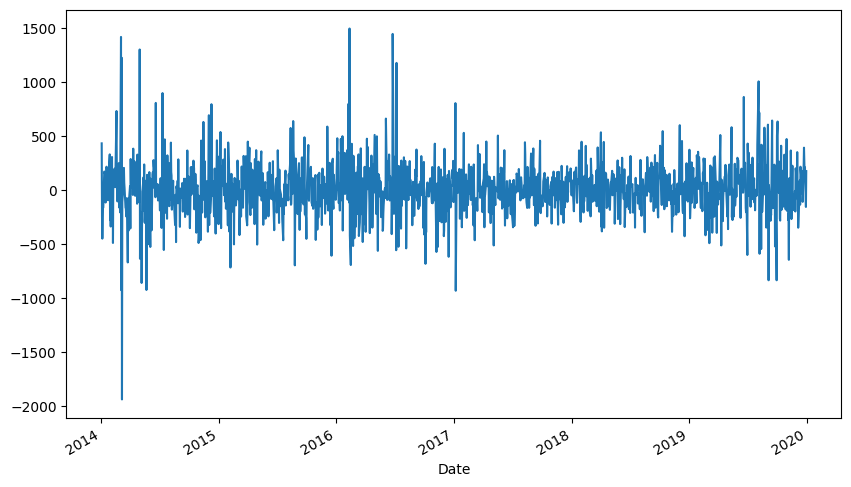

In [ ]:
plt.figure(figsize=(10, 6))
train_price.diff(1).dropna().plot()

In [ ]:
teste_estacionaria(train_high.diff(1).dropna())

0.0
Série estacionaria


<Axes: xlabel='Date'>

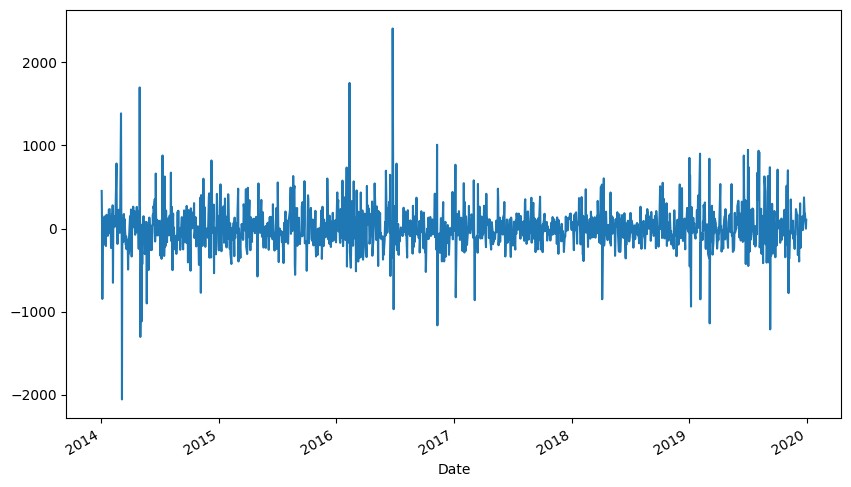

In [ ]:
plt.figure(figsize=(10, 6))
train_high.diff(1).dropna().plot()

### Encontrando os parâmetros para o Arima

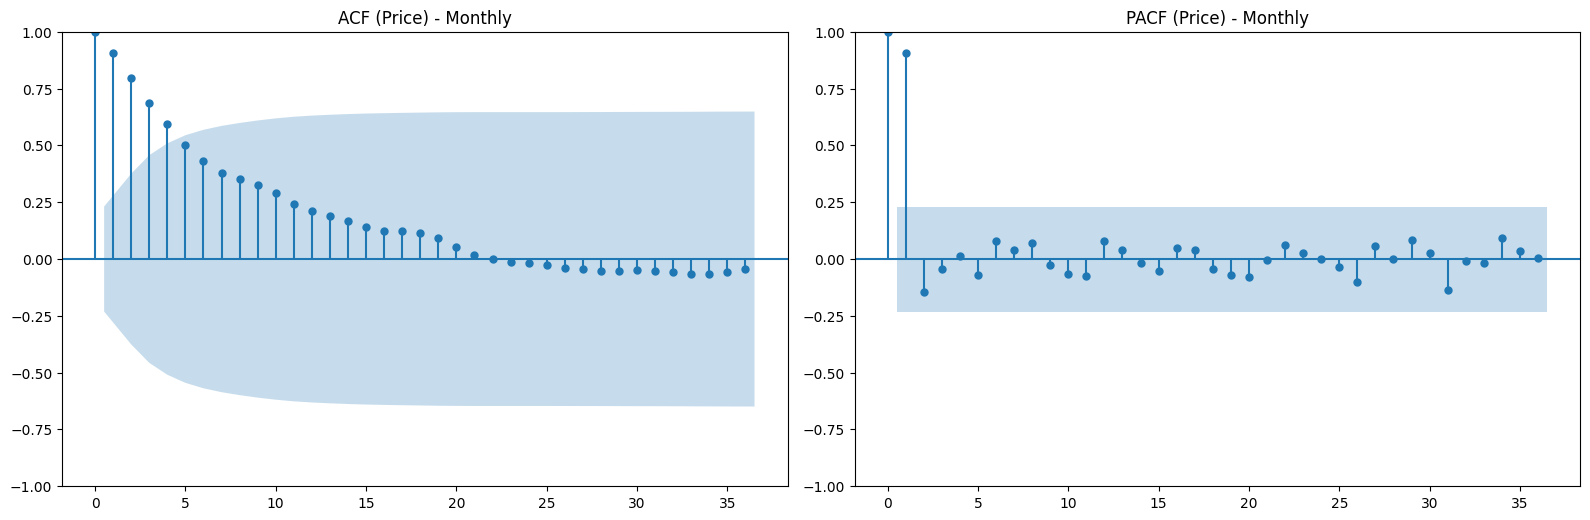

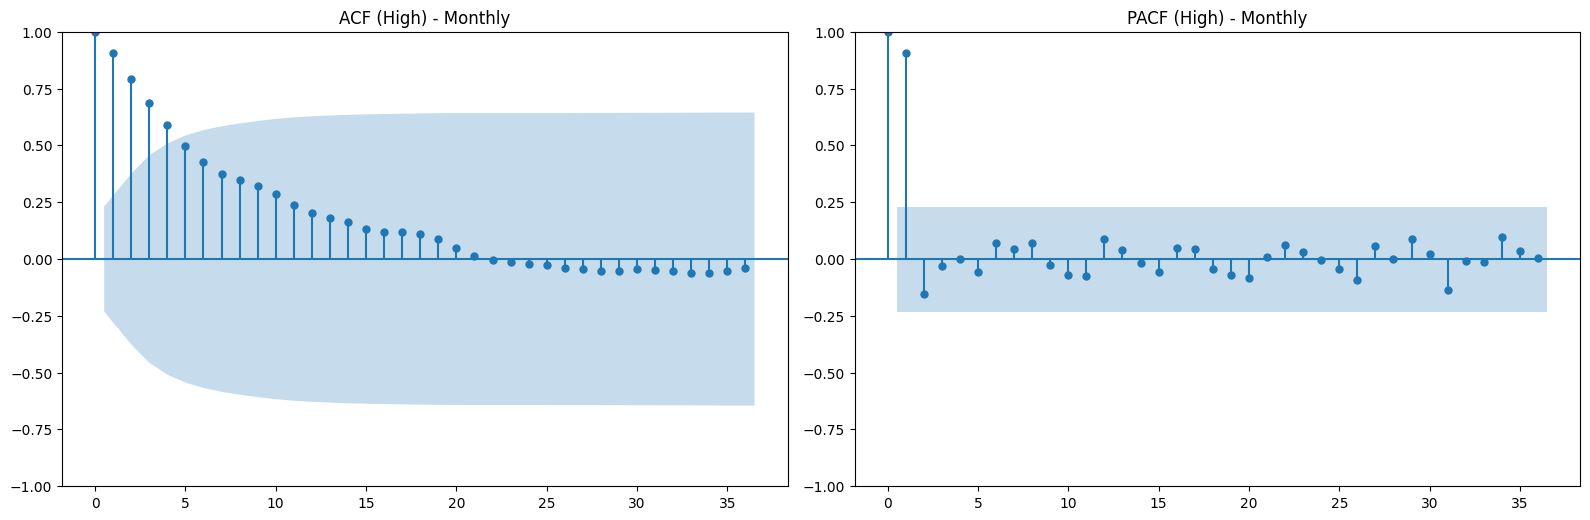

In [ ]:
acf_pacf_monthly(train_price, 36, 'Price')
acf_pacf_monthly(train_high, 36, 'High')

### GrideSearch

In [ ]:
p_price = 1
d_price = 1

p_high = 1
d_high = 1

q_price_values = [0, 1, 2, 3, 4]
q_high_values = [0, 1, 2, 3, 4]

best_mse_price = float('inf')
best_mse_high = float('inf')
best_params = {}


for q_price, q_high in itertools.product(q_price_values, q_high_values):
    order_price = (p_price, d_price, q_price)
    order_high = (p_high, d_high, q_high)


    model_price = SARIMAX(train_price, order=order_price)
    fitted_model_price = model_price.fit()

    model_high = SARIMAX(train_high, order=order_high)
    fitted_model_high = model_high.fit()

    mse_price = np.mean((fitted_model_price.fittedvalues - train_price)**2)
    mse_high = np.mean((fitted_model_high.fittedvalues - train_high)**2)


    if mse_price < best_mse_price and mse_high < best_mse_high:
        best_mse_price = mse_price
        best_mse_high = mse_high
        best_params = {'q_price': q_price, 'q_high': q_high}


print("Melhores parâmetros encontrados:")
print(best_params)

### Predição Price e Predição High

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


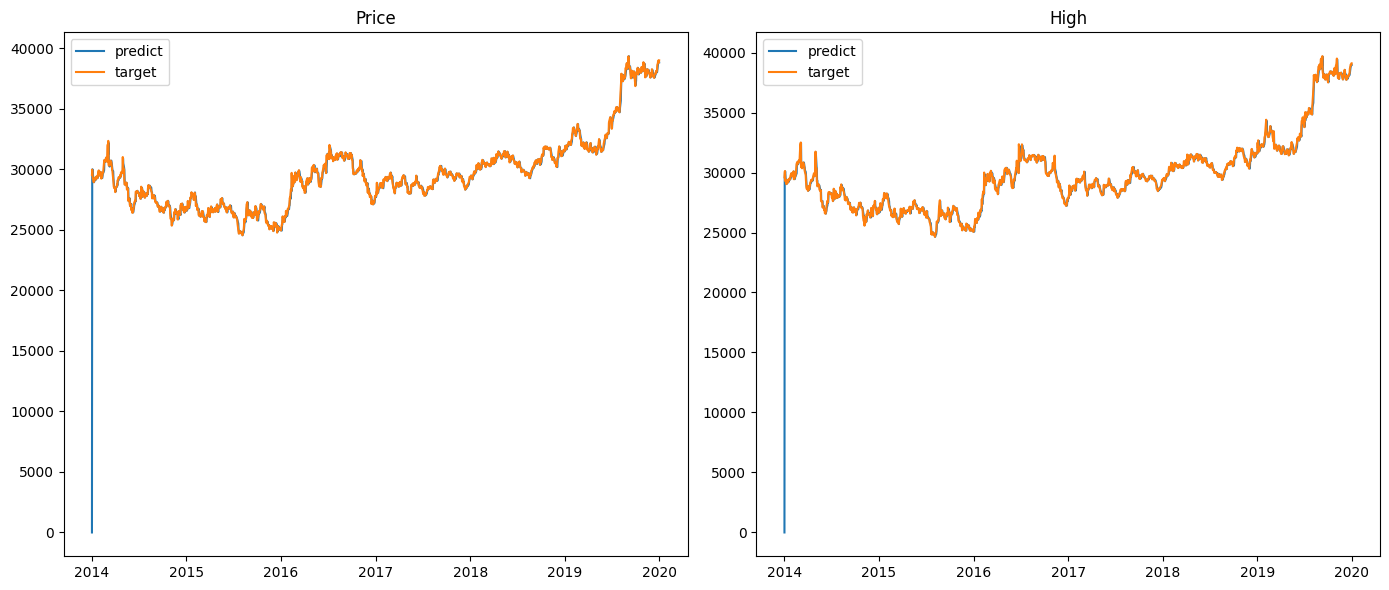

In [ ]:
best_q_price = best_params['q_price']
best_q_high = best_params['q_high']


best_order_price = (p_price, d_price, best_q_price)
model_price = SARIMAX(train_price, order=best_order_price)
fitted_model_price = model_price.fit()


best_order_high = (p_high, d_high, best_q_high)
model_high = SARIMAX(train_high, order=best_order_high)
fitted_model_high = model_high.fit()


prev_train_price = fitted_model_price.predict()
prev_train_high = fitted_model_high.predict()


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

axes[0].set_title("Price")
axes[0].plot(prev_train_price, label='predict')
axes[0].plot(train_price, label='target')
axes[0].legend(loc='best')

axes[1].set_title("High")
axes[1].plot(prev_train_high, label='predict')
axes[1].plot(train_high, label='target')
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()


In [ ]:
MAPE(train_price, prev_train_price)

0.006390282671105964

In [ ]:
MAPE(train_high, prev_train_high)

0.006337665215950905

### Ruído

In [ ]:
ruido_price = train_price - prev_train_price
ruido_high = train_high - prev_train_high

In [ ]:
plt.figure(figsize=(10, 6))
ruido_price.plot()

In [ ]:
plt.figure(figsize=(10, 6))
ruido_high.plot()

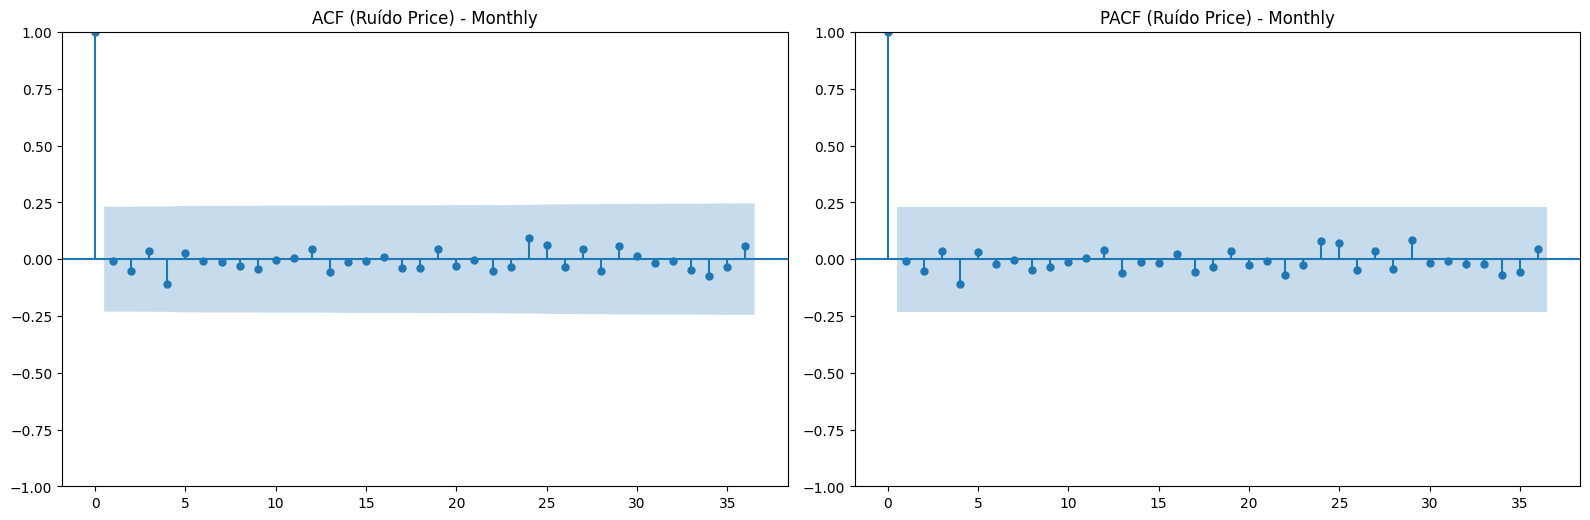

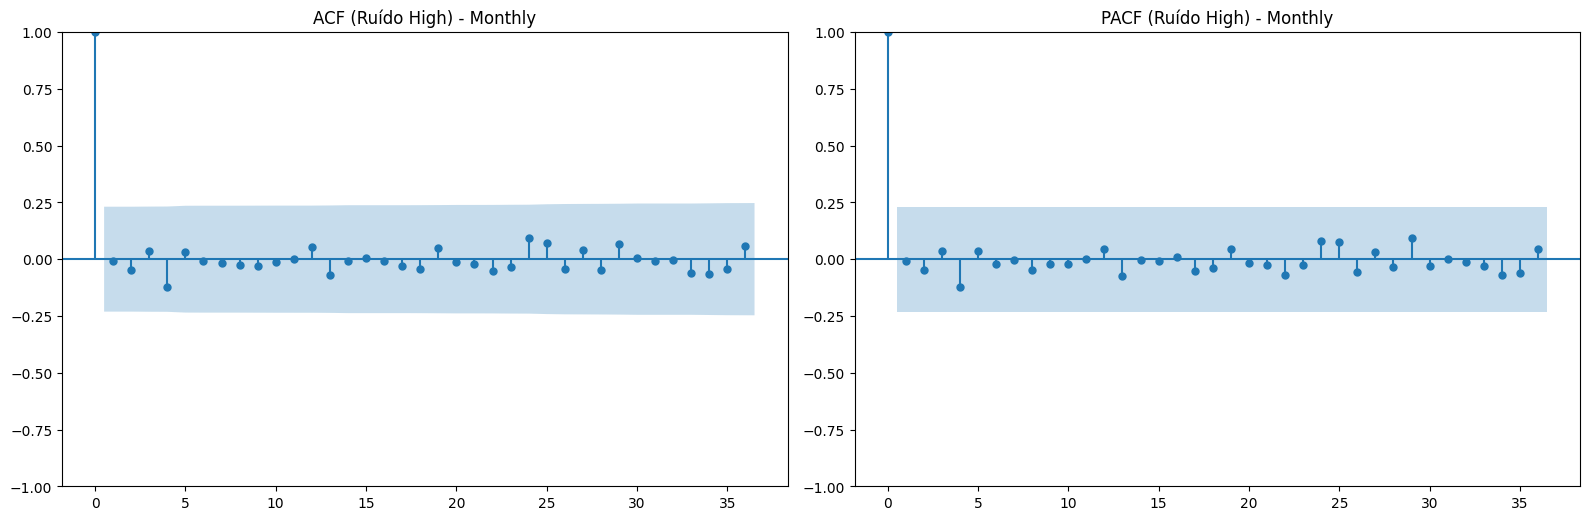

In [ ]:
acf_pacf_monthly(ruido_price, 36, 'Ruído Price')
acf_pacf_monthly(ruido_high, 36, 'Ruído High')

### prev_test_price e prev_test_high


In [ ]:
forecast_index_price = test_price.index
prev_test_price = fitted_model_price.get_forecast(steps=len(test_price), index=forecast_index_price)

test_price.index = pd.to_datetime(test_price.index)
prev_test_price = fitted_model_price.get_forecast(steps=len(test_price), index=test_price.index)


forecast_index_high = test_high.index
prev_test_high = fitted_model_high.get_forecast(steps=len(test_high), index=forecast_index_high)

test_high.index = pd.to_datetime(test_high.index)
prev_test_high = fitted_model_high.get_forecast(steps=len(test_high), index=test_high.index)

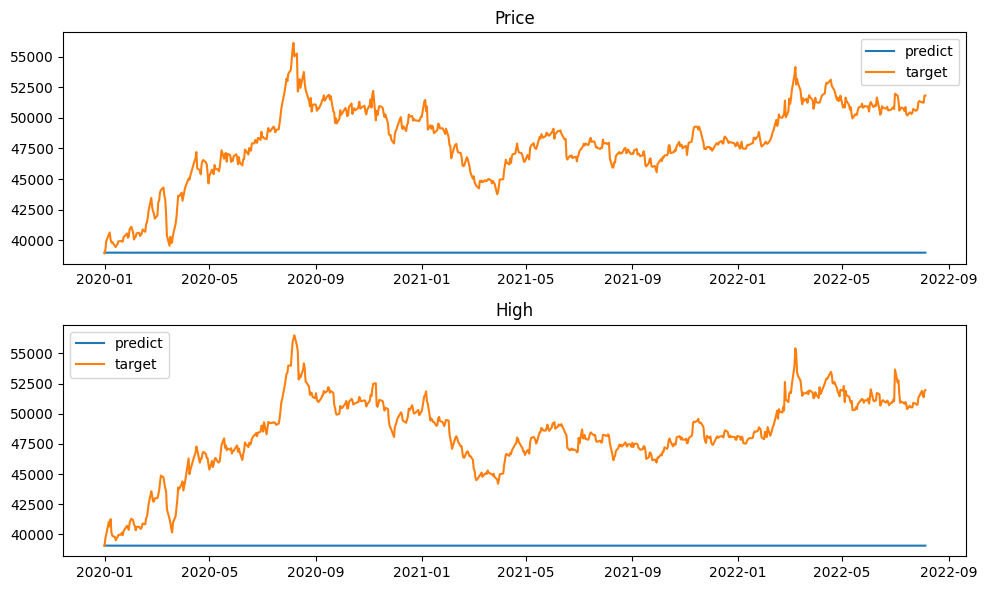

In [ ]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(prev_test_price.predicted_mean, label='predict')
plt.plot(test_price, label='target')
plt.legend(loc='best')
plt.title('Price')

plt.subplot(2, 1, 2)
plt.plot(prev_test_high.predicted_mean, label='predict')
plt.plot(test_high, label='target')
plt.legend(loc='best')
plt.title('High')

plt.tight_layout()
plt.show()


In [ ]:
MAPE(test_price, prev_test_price.predicted_mean)

0.1850007422248049

In [ ]:
MAPE(test_high, prev_test_high.predicted_mean)

0.1882259681488359